# Simple RAG pipeline

This notebook demonstrates how to build a simple Retrieval-Augmented Generation (RAG) pipeline using LangChain and various other libraries. RAG is a technique that combines the power of large language models with the ability to retrieve relevant information from a knowledge base.

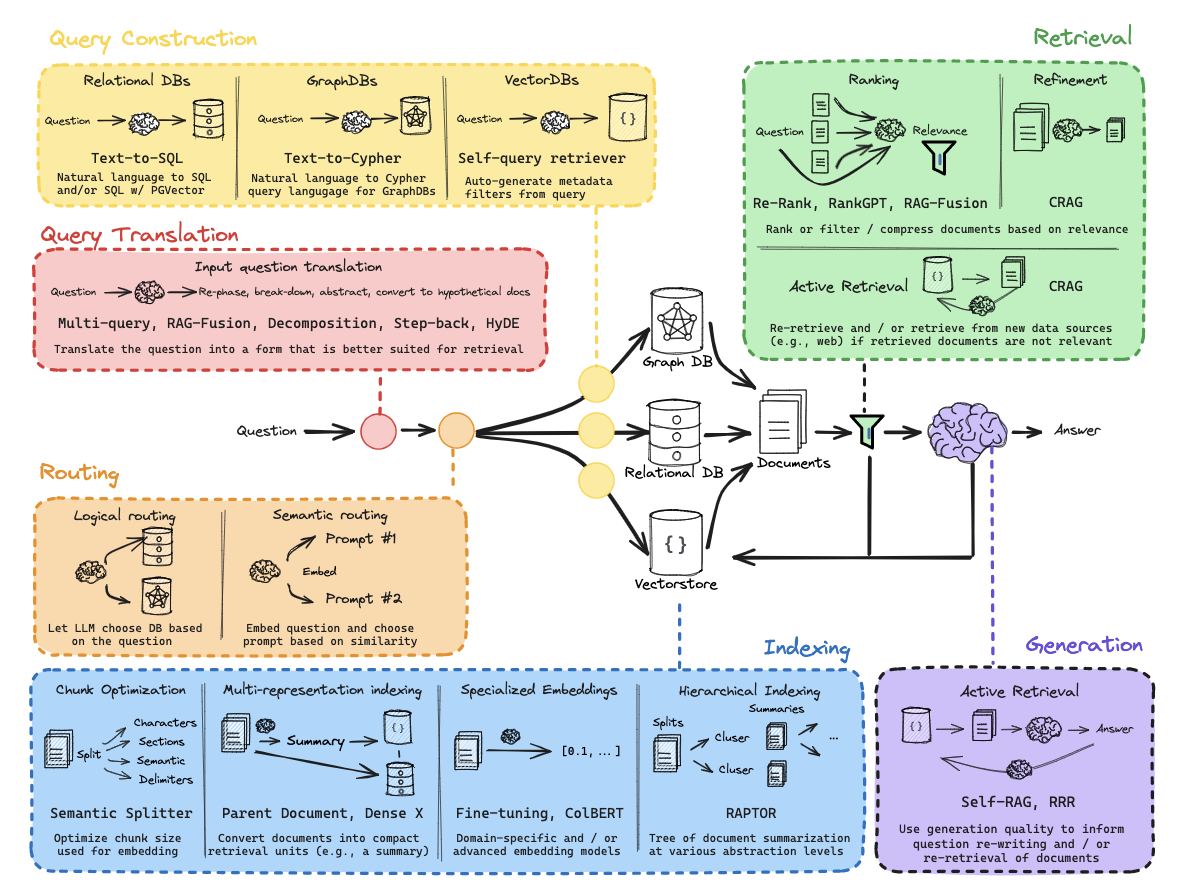

## Setup

### Set Environment Vars and API Keys


First, we need to set up our environment variables and API keys. This is crucial for accessing various services and tracking our LangChain usage.

In [ ]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")


### Indexing

Indexing is the process of preparing our documents for efficient retrieval. This involves several steps:


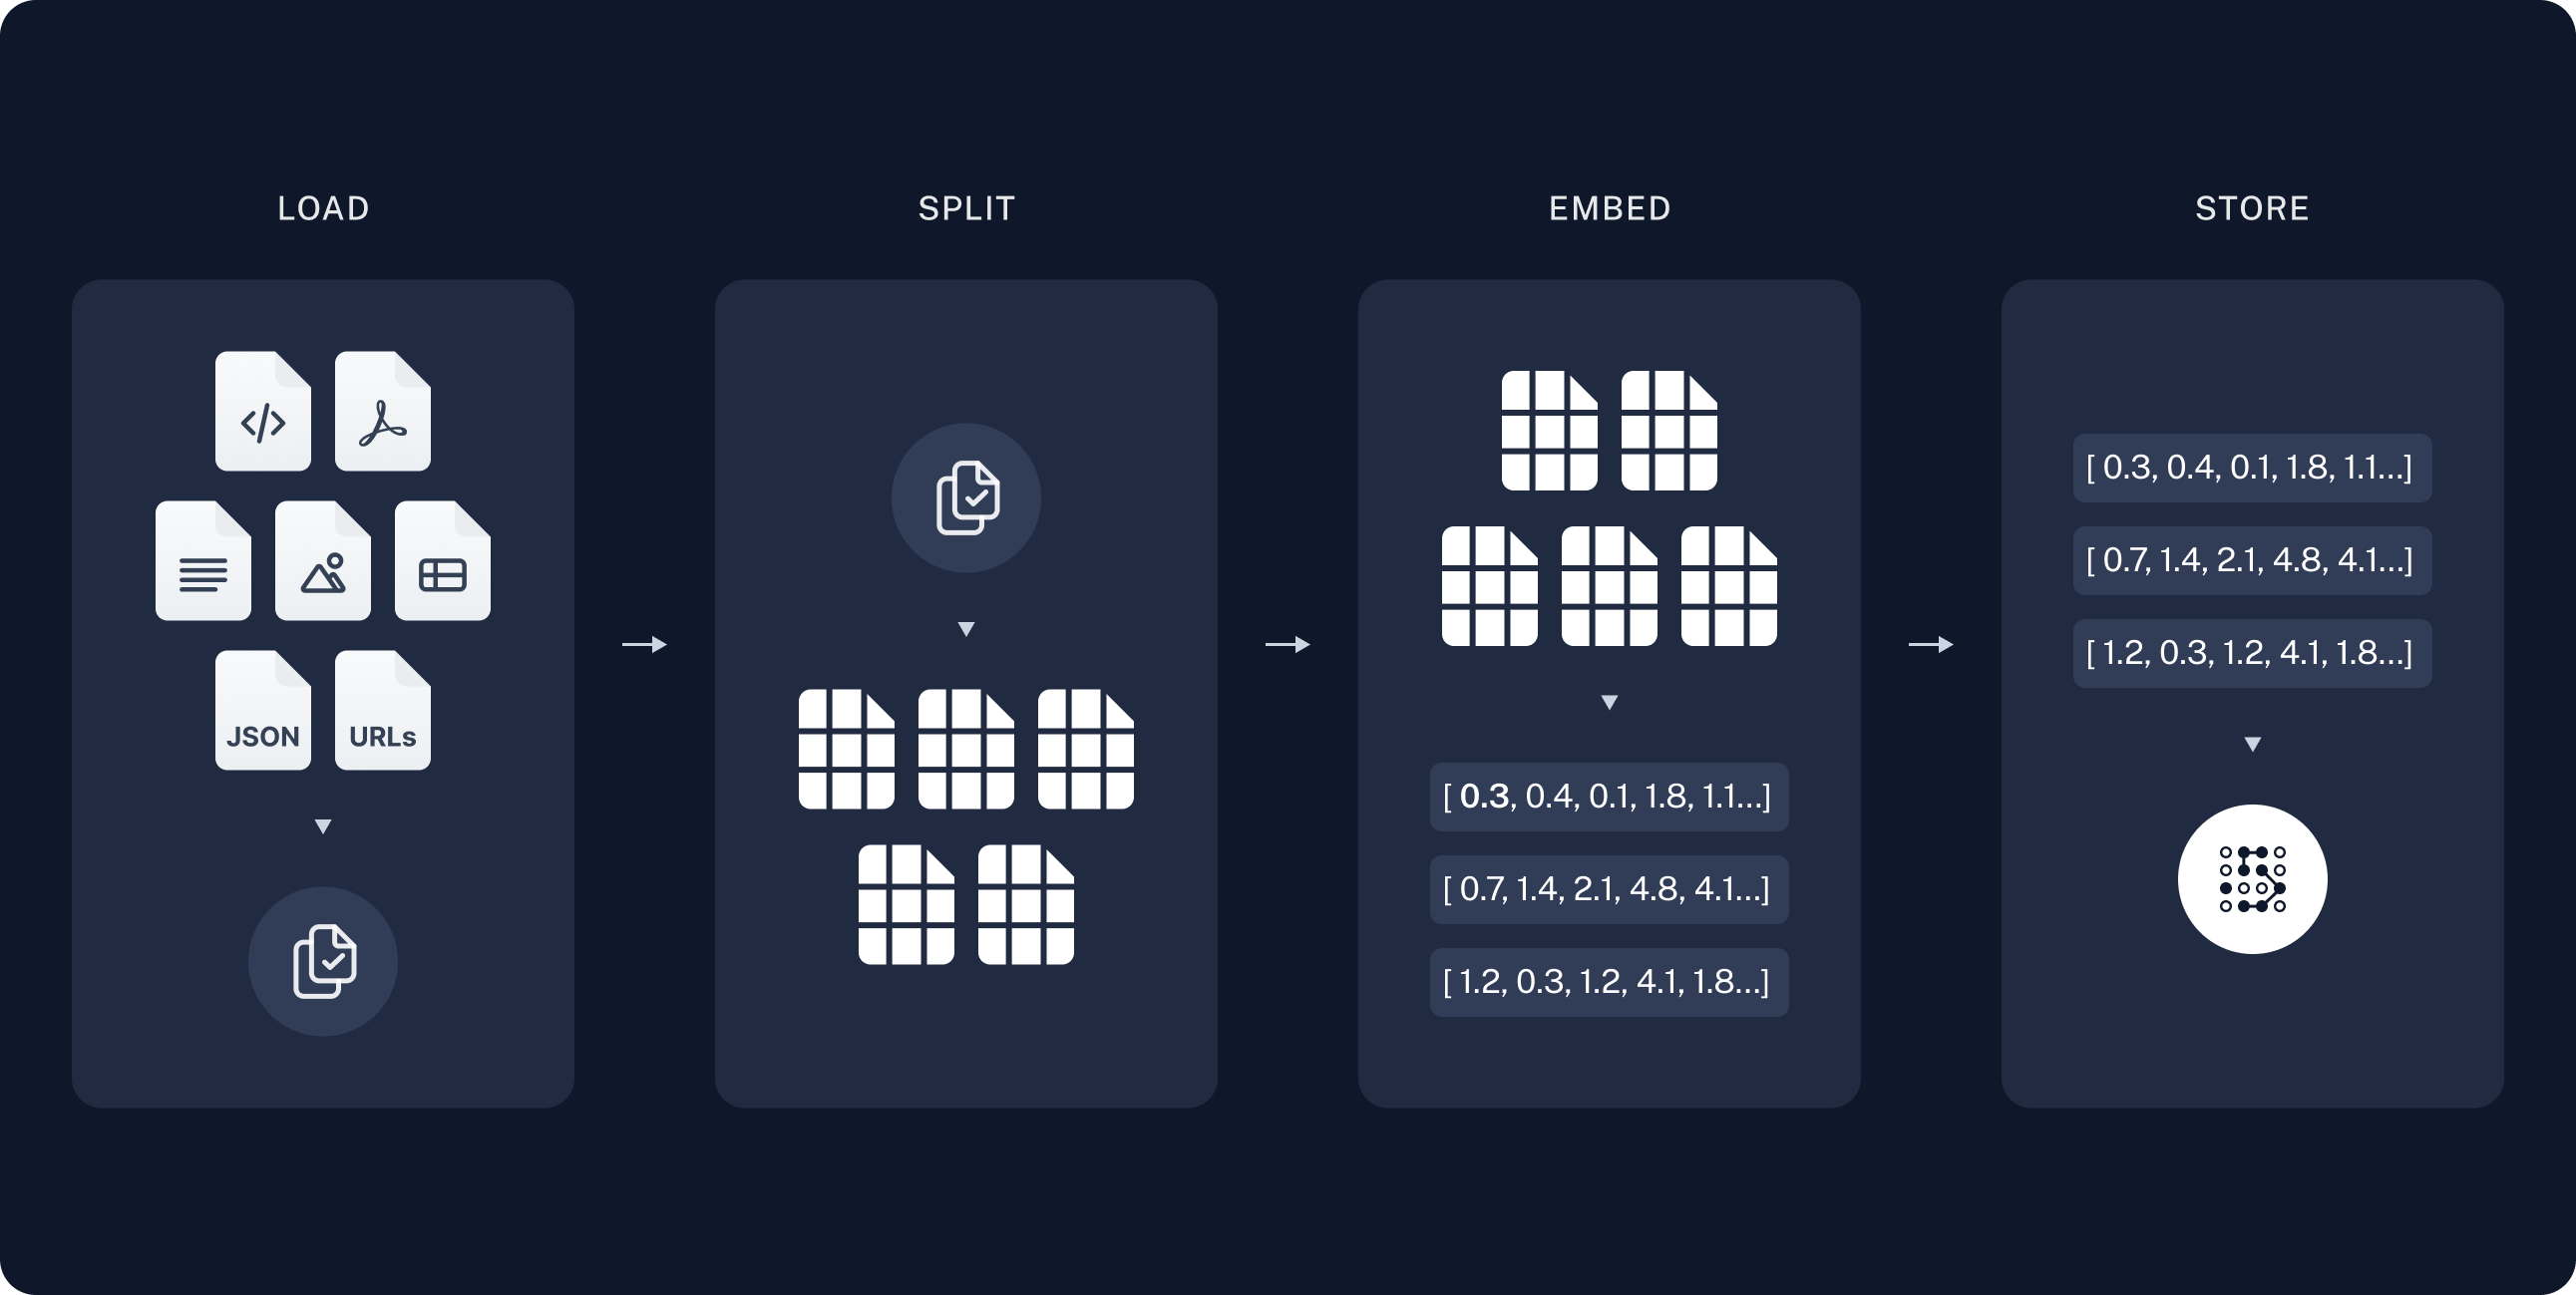

#### 1. Document Loading


We use a WebBaseLoader to load content from a specific URL. In this case, we're loading a blog post about AI agents.

In [ ]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

#### 2. Text Splitting

We split the loaded document into smaller chunks for more efficient processing and retrieval.


In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

#### 3. Text Embedding


We use the OllamaEmbedding model to convert our text chunks into numerical vectors.


In [ ]:
from langchain_ollama import OllamaEmbedding

embeddings = OllamaEmbedding(model='mxbai-embed-large')
query_result = embeddings.embed_query(question)
document_result = embeddings.embed_query(document)
len(query_result)

#### Similarity

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

#### Vector Store Creation

We create a FAISS vector store to efficiently store and retrieve our embedded documents.


In [ ]:
# Index
from langchain_community.vectorstores import FAISS
vectorstore = FAISS.from_documents(documents=splits, 
                                    embedding=embeddings)

retriever = vectorstore.as_retriever()

### Retrieval

Now that we have our indexed documents, we can perform retrieval operations.


In [ ]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")


In [ ]:
len(docs)


In [ ]:
docs

### Generation

The final step in our RAG pipeline is to generate a response based on the retrieved documents.


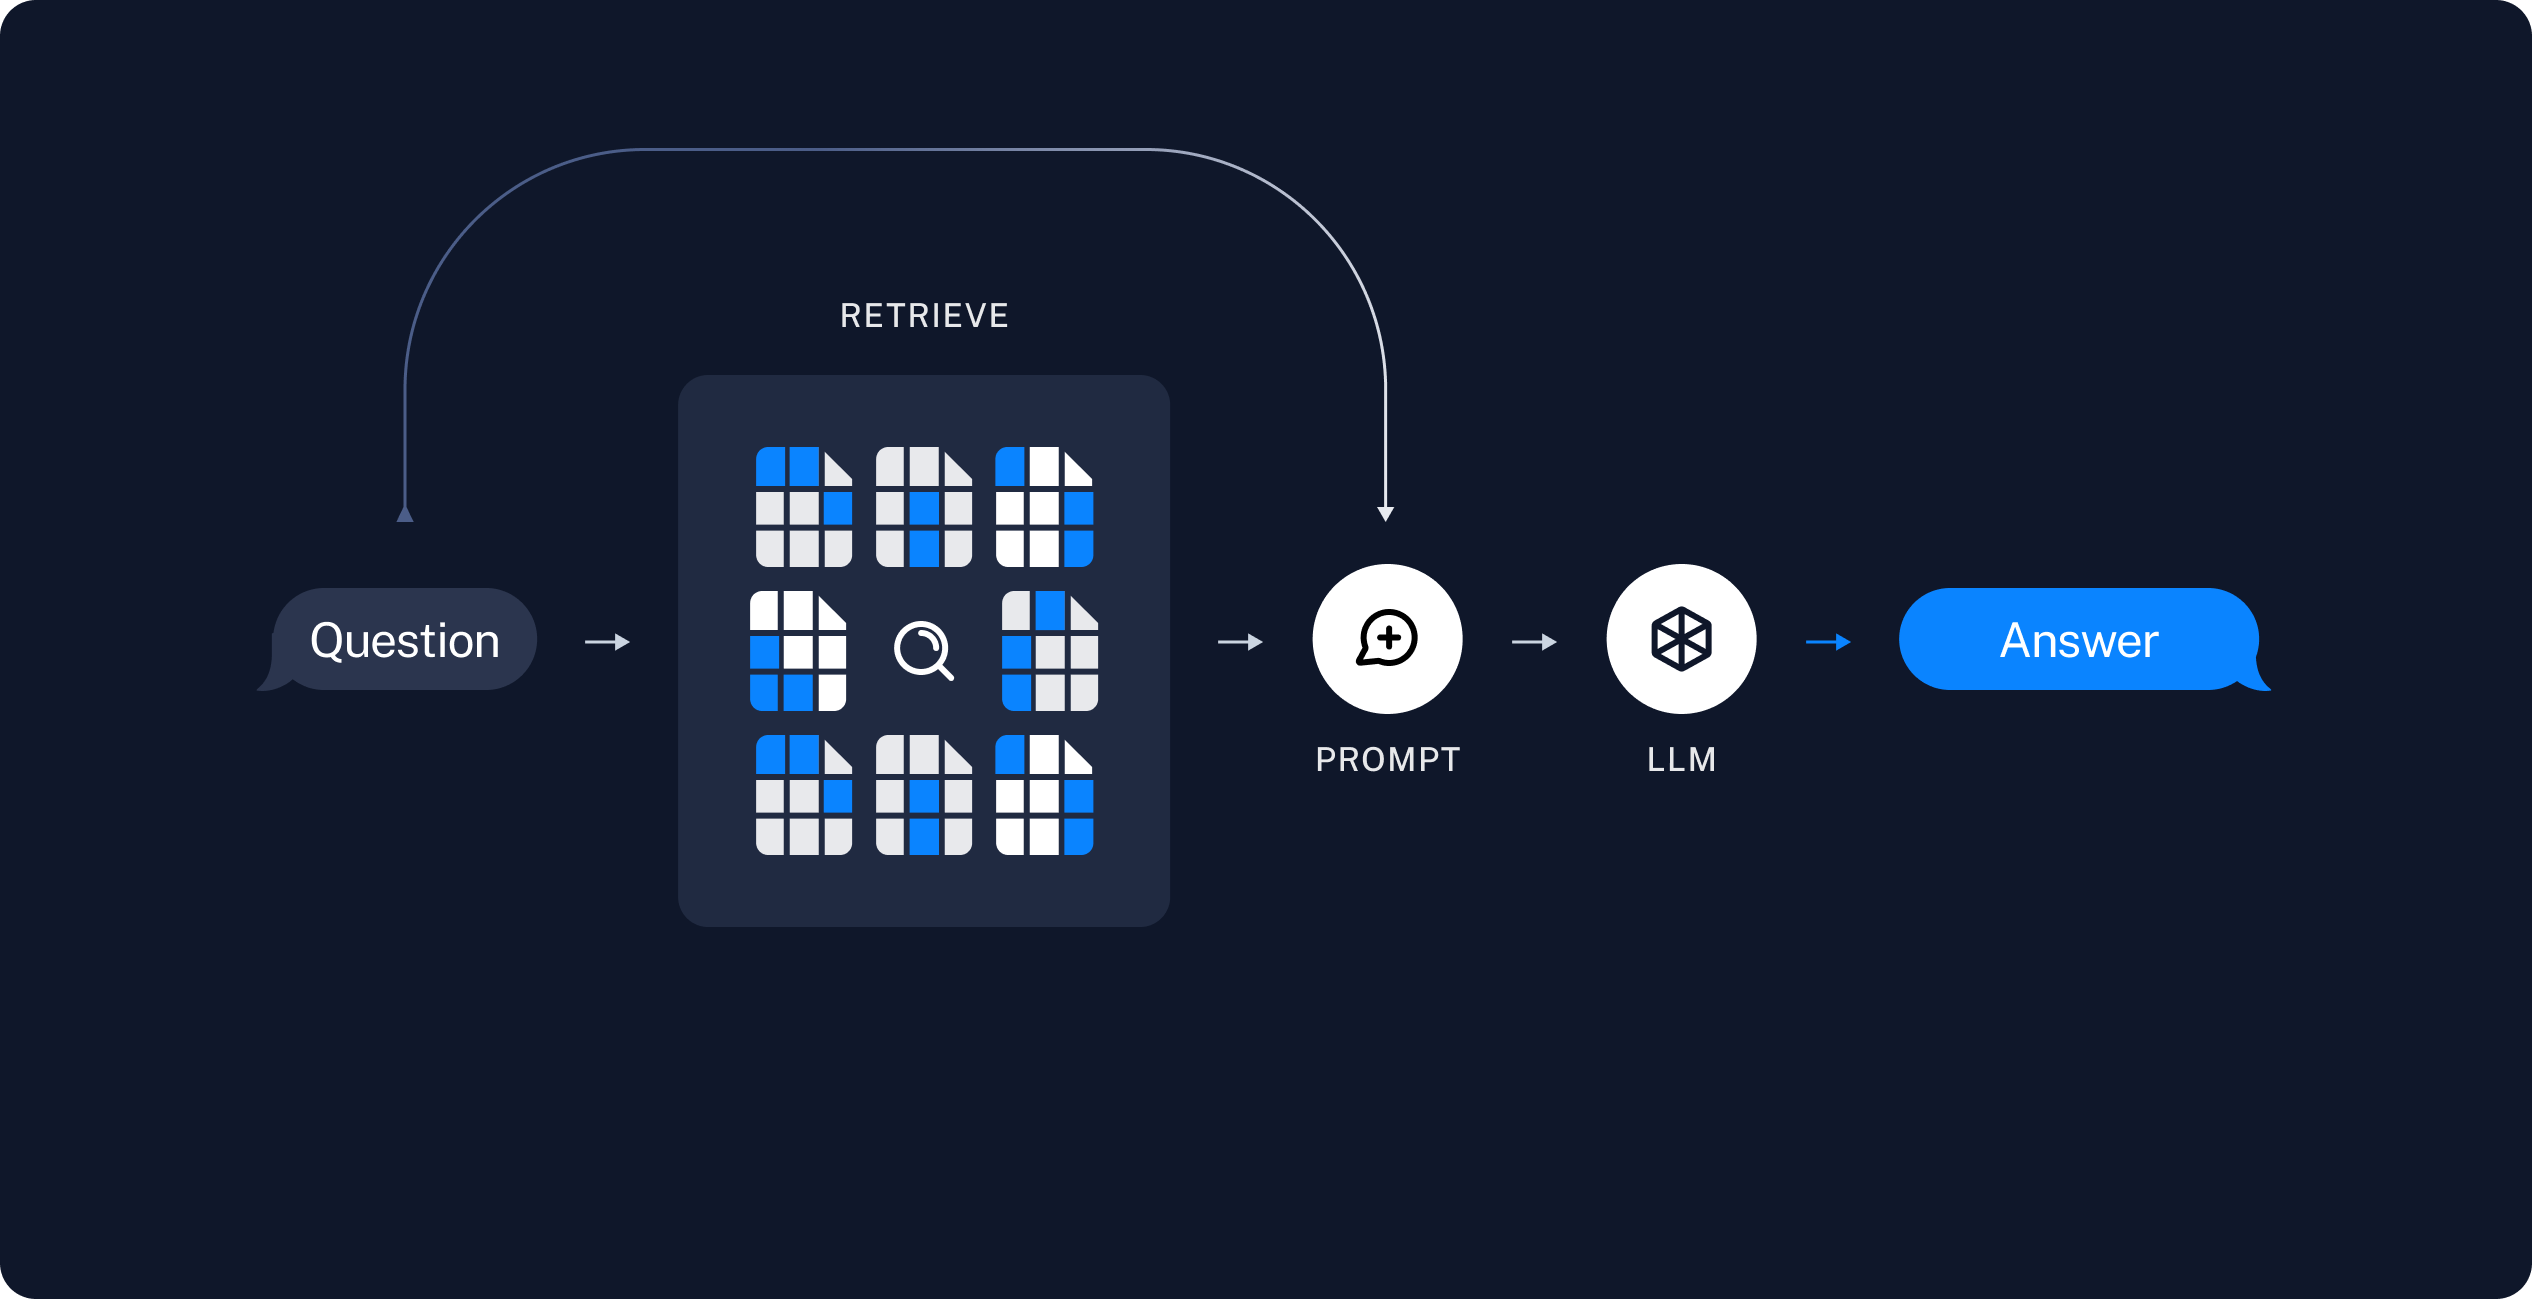

In [ ]:
from langchain_ollama import ChatOllama
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

In [ ]:
# LLM
llm = ChatOllama(model = 'llama3.1',temperature = 0)


In [ ]:
# Chain
chain = prompt | llm

In [ ]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

#### Different chain 

In [ ]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_hub_rag
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

### Full code

In [ ]:


import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbedding
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain import hub



# Load blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)


# Embedding 
embeddings = OllamaEmbedding(model='mxbai-embed-large')

# Vectorstore
vectorstore = FAISS.from_documents(documents=splits, 
                                    embedding=embeddings)

retriever = vectorstore.as_retriever()



# Chaining
prompt_hub_rag = hub.pull("rlm/rag-prompt")
llm = ChatOllama(model='llama3.1',temperature = 0)
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_hub_rag
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

## Conclusion


This notebook demonstrates a simple yet powerful RAG pipeline. By combining document loading, text splitting, embedding, retrieval, and generation, we create a system that can answer questions based on the content of specific documents. This approach enhances the capabilities of large language models by grounding them in specific, retrievable information.

## References

- [Document loaders](https://python.langchain.com/docs/integrations/document_loaders/)
- [Splitters](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter)
- [Ollama Embeddings](https://python.langchain.com/docs/integrations/text_embedding/ollama/)
- [Vectorstores](https://python.langchain.com/docs/integrations/vectorstores/)
- [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss/)
- [Chains](https://python.langchain.com/docs/how_to/sequence/)